<a href="https://colab.research.google.com/github/suna0107/ANN_DL101/blob/main/%E2%98%85(250422)Attention(2)multi_head_fc_relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Attention 구조(2) Multi-head 어텐션 구조

# 1. 데이터 전처리

✅ 1. 데이터 로드 및 결측치 처리 및 라벨 변환

In [ ]:
import pandas as pd
import numpy as np

# 1. 데이터 로드
item_df = pd.read_pickle("/content/item_df_vec.pkl")

# 2. 결측치 처리 (NaN → 0 벡터)
item_df['hs_vec_800'] = item_df['hs_vec_800'].apply(
    lambda x: x if isinstance(x, (list, np.ndarray)) else np.zeros(800)
)

# 3. 라벨 생성 ('결과' → 0/1)
item_df['label'] = item_df['결과'].map({'해당': 1, '비해당': 0}).astype(int)

# 🔍 확인
print("🧩 전체 샘플 수:", len(item_df))
print("📌 item_vec 차원:", len(item_df['item_vec'].iloc[0]))
print("📌 company_vecs 차원:", len(item_df['company_vecs'].iloc[0]))
print("📌 hs_vec_800 차원:", len(item_df['hs_vec_800'].iloc[0]))
print("🎯 label 분포:", item_df['label'].value_counts().to_dict())


🧩 전체 샘플 수: 2804
📌 item_vec 차원: 384
📌 company_vecs 차원: 384
📌 hs_vec_800 차원: 800
🎯 label 분포: {0: 2480, 1: 324}


2. Train / Val / Test 분리

In [ ]:
from sklearn.model_selection import train_test_split

# 1. 벡터 및 라벨 추출
item_vecs = np.stack(item_df['item_vec'].values)
comp_vecs = np.stack(item_df['company_vecs'].values)
hs_vecs   = np.stack(item_df['hs_vec_800'].values)
labels    = item_df['label'].values

# 2. Train+Val / Test 분리 (80/20)
item_temp, item_test, comp_temp, comp_test, hs_temp, hs_test, y_temp, y_test = train_test_split(
    item_vecs, comp_vecs, hs_vecs, labels, test_size=0.2, stratify=labels, random_state=42
)

# 3. Train / Val 분리 (80/20 of temp)
item_train, item_val, comp_train, comp_val, hs_train, hs_val, y_train, y_val = train_test_split(
    item_temp, comp_temp, hs_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=42
)

# 🔍 확인
print("🟢 Train 샘플 수:", len(y_train))
print("🟡 Val 샘플 수:", len(y_val))
print("🔵 Test 샘플 수:", len(y_test))


🟢 Train 샘플 수: 1794
🟡 Val 샘플 수: 449
🔵 Test 샘플 수: 561


# 2. Dataset 정의 및 dataloader 생성


(1) 딥러닝 모델 학습 시 필요한 데이터 형태로 변환하는 단계
- 배치 단위로 데이터 공급 필요

(2) 넘파이 배열 → PyTorch Tensor로 변환
TensorDataset으로 4개의 벡터(item, company, hs, label)를 묶음
DataLoader로 배치 처리 및 셔플 적용


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1. 넘파이 → 텐서 변환
def to_tensor(x): return torch.tensor(x, dtype=torch.float32)

item_train = to_tensor(item_train)
comp_train = to_tensor(comp_train)
hs_train   = to_tensor(hs_train)
y_train    = to_tensor(y_train).unsqueeze(1)

item_val = to_tensor(item_val)
comp_val = to_tensor(comp_val)
hs_val   = to_tensor(hs_val)
y_val    = to_tensor(y_val).unsqueeze(1)

item_test = to_tensor(item_test)
comp_test = to_tensor(comp_test)
hs_test   = to_tensor(hs_test)
y_test    = to_tensor(y_test).unsqueeze(1)

# 2. TensorDataset 생성
train_dataset = TensorDataset(item_train, comp_train, hs_train, y_train)
val_dataset   = TensorDataset(item_val, comp_val, hs_val, y_val)
test_dataset  = TensorDataset(item_test, comp_test, hs_test, y_test)

# 3. DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64)
test_loader  = DataLoader(test_dataset, batch_size=64)

# 🔍 확인
print("✅ 학습 배치 수:", len(train_loader))
print("✅ 검증 배치 수:", len(val_loader))
print("✅ 테스트 배치 수:", len(test_loader))


✅ 학습 배치 수: 29
✅ 검증 배치 수: 8
✅ 테스트 배치 수: 9


# 3. multihead 어텐션 모델 정의

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttentionClassifier(nn.Module):  # 1️⃣ PyTorch의 nn.Module을 상속하여 모델 정의
    def __init__(self, item_dim=384, company_dim=384, hs_dim=800, d_model=384, num_heads=4, hidden_dim=128):
        super().__init__()  # 2️⃣ 부모 클래스 초기화

        # 3️⃣ 각 입력 벡터를 동일한 차원(d_model)으로 맞추기 위한 Linear Layer
        self.proj_item = nn.Linear(item_dim, d_model)        # item_vec: 384 → 384
        self.proj_company = nn.Linear(company_dim, d_model)  # company_vec: 384 → 384
        self.proj_hs = nn.Linear(hs_dim, d_model)            # hs_vec: 800 → 384

        # 4️⃣ Multi-Head Attention Layer 정의
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, batch_first=True)

        # 5️⃣ Attention 결과를 입력으로 받아 최종 분류할 FC Layer 정의
        self.classifier = nn.Sequential(
            nn.Linear(d_model, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1)  # 6️⃣ 출력은 logit (Sigmoid는 나중에)
        )


    def forward(self, item_vec, company_vec, hs_vec):  # 7️⃣ 모델의 forward pass 정의
        # 8️⃣ 각각의 벡터를 Linear 통과 → 동일한 차원으로 변환
        item_proj = self.proj_item(item_vec)        # (B, 384)
        comp_proj = self.proj_company(company_vec)  # (B, 384)
        hs_proj = self.proj_hs(hs_vec)              # (B, 384)

        # 9️⃣ 3개 벡터를 묶어 3개의 시퀀스로 만듦 → (B, 3, 384)
        x = torch.stack([item_proj, comp_proj, hs_proj], dim=1)

        # 🔟 Multi-Head Attention 적용 (Self-Attention)
        attn_output, _ = self.attn(x, x, x)  # Q=K=V=x → (B, 3, 384)

        # 1️⃣1️⃣ Attention 결과 3개 벡터 평균 → 하나의 벡터로 (B, 384)
        pooled = attn_output.mean(dim=1)

        # 1️⃣2️⃣ 최종 분류기 통과 → (B, 1) logit 출력
        return self.classifier(pooled)


# 4. 예측 모델 학습 및 검증 함수

1. 모델 초기화 및 학습 준비(손실함수, 옵티마이저, 스케줄러 정의 (pos_weight 적용))

In [ ]:
# ✅ 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 불균형 대응을 위한 pos_weight 계산
from collections import Counter
counter = Counter(y_train.numpy().flatten())
neg, pos = counter[0], counter[1]
pos_weight = torch.tensor(neg / pos, dtype=torch.float32).to(device)

# ✅ 모델 초기화
model = MultiHeadAttentionClassifier().to(device)

# ✅ 손실 함수 (Logits 기반 + 불균형 대응)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# ✅ 옵티마이저 & 스케줄러
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


 2. train, val 함수 정의

In [ ]:
from sklearn.metrics import f1_score, accuracy_score

# ✅ 학습 함수
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for item_vec, comp_vec, hs_vec, y in loader:
        item_vec, comp_vec, hs_vec, y = item_vec.to(device), comp_vec.to(device), hs_vec.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(item_vec, comp_vec, hs_vec)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# ✅ 검증 함수
def eval_epoch(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for item_vec, comp_vec, hs_vec, y in loader:
            item_vec, comp_vec, hs_vec, y = item_vec.to(device), comp_vec.to(device), hs_vec.to(device), y.to(device)
            logits = model(item_vec, comp_vec, hs_vec)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    return f1_score(all_labels, all_preds), accuracy_score(all_labels, all_preds)


3. 학습 루프 (Early Stopping 포함)

In [ ]:
best_f1 = 0 # 가장 높은 F1 점수 저장할 변수 선
patience = 3 # 성능이 3번 연속 향상되지 않으면 중단.
counter = 0 # 성능이 향상되지 않은 횟수 카운트

for epoch in range(1, 21):  # 최대 20 에폭까지 학
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_f1, val_acc = eval_epoch(model, val_loader, device) #검증 데이터로 F1 점수와 정확도 계
    scheduler.step() #학습률 조정 스케줄러: 일정 에폭마다 학습률 감소

    print(f"📘 Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | F1: {val_f1:.4f}")

    if val_f1 > best_f1: #현재 F1 점수가 최고 기록보다 좋으면.
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_multihead_attention_model.pt") # 모델 파라미터 저장 (최고 성능 모델 저장)
        print("✅ Best model saved.")
        counter = 0 # 성능 향상됐으므로 카운터 리셋
    else:
        counter += 1 # 성능 향상 안되면 카운터 증가
        if counter >= patience:
            print("⛔ Early stopping triggered!")
            break


📘 Epoch 01 | Train Loss: 1.1779 | Val Acc: 0.8374 | F1: 0.3967
✅ Best model saved.
📘 Epoch 02 | Train Loss: 0.9846 | Val Acc: 0.8263 | F1: 0.4868
✅ Best model saved.
📘 Epoch 03 | Train Loss: 0.8452 | Val Acc: 0.7862 | F1: 0.4545
📘 Epoch 04 | Train Loss: 0.7456 | Val Acc: 0.8107 | F1: 0.4910
✅ Best model saved.
📘 Epoch 05 | Train Loss: 0.7142 | Val Acc: 0.7194 | F1: 0.4324
📘 Epoch 06 | Train Loss: 0.6591 | Val Acc: 0.7572 | F1: 0.4577
📘 Epoch 07 | Train Loss: 0.6235 | Val Acc: 0.8174 | F1: 0.5176
✅ Best model saved.
📘 Epoch 08 | Train Loss: 0.6045 | Val Acc: 0.8129 | F1: 0.5227
✅ Best model saved.
📘 Epoch 09 | Train Loss: 0.5800 | Val Acc: 0.7661 | F1: 0.4670
📘 Epoch 10 | Train Loss: 0.5169 | Val Acc: 0.8062 | F1: 0.5140
📘 Epoch 11 | Train Loss: 0.4855 | Val Acc: 0.8129 | F1: 0.5227
⛔ Early stopping triggered!


# 5. test 데이터로 모델 성능 평가

In [ ]:
# 1️⃣ 모델 로드
model.load_state_dict(torch.load("best_multihead_attention_model.pt", map_location=device))
model.eval() #model.eval()로 평가 모드 전환 → Dropout 등 비활성화


MultiHeadAttentionClassifier(
  (proj_item): Linear(in_features=384, out_features=384, bias=True)
  (proj_company): Linear(in_features=384, out_features=384, bias=True)
  (proj_hs): Linear(in_features=800, out_features=384, bias=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [ ]:
# 2️⃣ 테스트 데이터 평가
all_preds, all_labels, all_probs = [], [], []
with torch.no_grad():
    for item_vec, comp_vec, hs_vec, y in test_loader:
        item_vec = item_vec.to(device)
        comp_vec = comp_vec.to(device)
        hs_vec = hs_vec.to(device)
        y = y.to(device)

        logits = model(item_vec, comp_vec, hs_vec)
        probs = torch.sigmoid(logits)  # logits → 확률
        preds = (probs > 0.5).float()  # Threshold=0.5 기준으로 0 or 1
# 모든 예측 결과와 실제 라벨 저장
        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

In [ ]:
# 3️⃣ 성능 지표 계산
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = np.array(all_labels).astype(int)
y_pred = np.array(all_preds).astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("\n📊 [Test Set Evaluation]")
print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ Precision: {prec:.4f}")
print(f"✅ Recall   : {rec:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"📌 Confusion Matrix:\n{cm}")


📊 [Test Set Evaluation]
✅ Accuracy : 0.8111
✅ Precision: 0.3660
✅ Recall   : 0.8615
✅ F1 Score : 0.5138
📌 Confusion Matrix:
[[399  97]
 [  9  56]]


#6. 성능 향상을 위한 최적 threshold 찾기

- PR curve, AUC 커브



1️⃣ Precision-Recall Curve 계산


In [ ]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# y_true = 실제 라벨, y_prob = 확률값 (Sigmoid 적용 후)
precision_vals, recall_vals, thresholds = precision_recall_curve(y_true, all_probs)
prc_auc = auc(recall_vals, precision_vals)

print(f"🔵 PRC AUC: {prc_auc:.4f}")


🔵 PRC AUC: 0.5891


2️⃣ 최적 F1 기준 Threshold 찾기

F1 Score 기준으로 가장 높은 점수를 주는 Threshold 탐색.

Precision-Recall 간 균형 최적화!

In [ ]:
# F1 점수 계산
f1_scores = 2 * (precision_vals * recall_vals) / (precision_vals + recall_vals + 1e-8)

# 최고 F1 Score와 해당 Threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"🔧 최적 Threshold: {best_threshold:.2f} | F1 Score: {best_f1:.4f}")


🔧 최적 Threshold: 0.81 | F1 Score: 0.5839


3️⃣ 최적 Threshold 기준으로 최종 평가

In [ ]:
# 최적 Threshold 반영
final_preds = (np.array(all_probs) > best_threshold).astype(int)

# 최종 성능 재계산
acc_final = accuracy_score(y_true, final_preds)
prec_final = precision_score(y_true, final_preds, zero_division=0)
rec_final = recall_score(y_true, final_preds)
f1_final = f1_score(y_true, final_preds)
cm_final = confusion_matrix(y_true, final_preds)

print(f"\n✅ 최종 평가 결과 @ Threshold {best_threshold:.2f}")
print(f"Accuracy : {acc_final:.4f}")
print(f"Precision: {prec_final:.4f}")
print(f"Recall   : {rec_final:.4f}")
print(f"F1 Score : {f1_final:.4f}")
print(f"📊 Confusion Matrix:\n{cm_final}")



✅ 최종 평가 결과 @ Threshold 0.81
Accuracy : 0.8966
Precision: 0.5493
Recall   : 0.6000
F1 Score : 0.5735
📊 Confusion Matrix:
[[464  32]
 [ 26  39]]


4️⃣ PRC 곡선 시각화

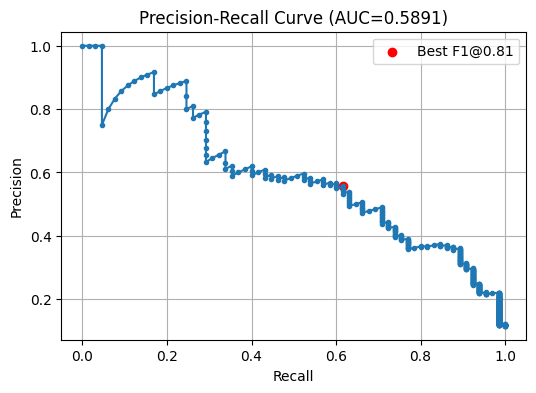

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(recall_vals, precision_vals, marker='.')
plt.scatter(recall_vals[best_idx], precision_vals[best_idx], color='red', label=f"Best F1@{best_threshold:.2f}")
plt.title(f"Precision-Recall Curve (AUC={prc_auc:.4f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


5. ROC Curve 시각화

🔵 ROC AUC: 0.8959


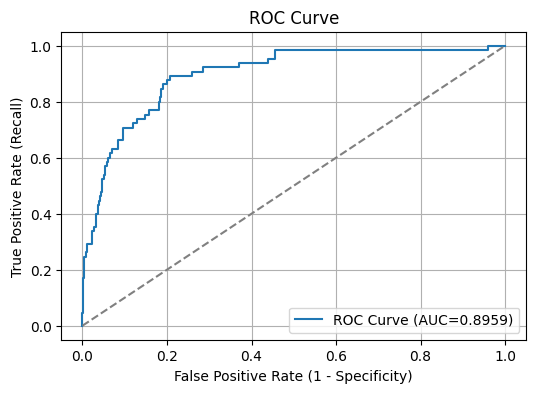

In [ ]:

from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve 계산
fpr, tpr, roc_thresholds = roc_curve(y_true, all_probs)
roc_auc = roc_auc_score(y_true, all_probs)

print(f"🔵 ROC AUC: {roc_auc:.4f}")

# ROC Curve 시각화
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 랜덤 분류기 기준선
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()